Uncomment the following to install dependencies through pip/conda

In [1]:
# import sys
# !pip install optuna
# !pip install -U scikit-learn
# !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
# !pip install pandas
# !pip install numpy

In [ ]:
# import sys
# !conda install conda-forge::optuna
# !conda install conda-forge::scikit-learn
# !conda install pytorch::pytorch 
# !conda install conda-forge::pandas
# !conda install conda-forge::numpy

In [ ]:
### Imports

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from statsmodels.stats.contingency_tables import mcnemar


import warnings
warnings.filterwarnings("ignore")

## 0. Data Visualization

In [5]:
df = pd.read_csv('../DL-2025-CW-data/Data_A.csv', names=['target', 'lvl1_sell_p', 'lvl1_sell_vol', 'lvl1_buy_p', 'lvl1_buy_vol', 'lvl2_sell_p', 'lvl2_sell_vol', 'lvl2_buy_p', 'lvl2_buy_vol', 'lvl3_sell_p', 'lvl3_sell_vol', 'lvl3_buy_p', 'lvl3_buy_vol', 'lvl4_sell_p', 'lvl4_sell_vol', 'lvl4_buy_p', 'lvl4_buy_vol', 'prev_midprice1', 'prev_midprice2', 'prev_midprice3', 'prev_midprice4', 'prev_midprice5'])
df.head()

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,lvl3_buy_vol,lvl4_sell_p,lvl4_sell_vol,lvl4_buy_p,lvl4_buy_vol,prev_midprice1,prev_midprice2,prev_midprice3,prev_midprice4,prev_midprice5
0,1,693200.0,126,692800.0,110,693300.0,50,692700.0,165,693400.0,...,50,693500.0,50,692500.0,250,0,1,0,1,0
1,0,650400.0,501,650200.0,106,650500.0,245,650100.0,259,650600.0,...,328,650700.0,141,649900.0,277,0,0,1,1,1
2,1,636200.0,153,635800.0,150,636300.0,100,635700.0,15,636400.0,...,110,636500.0,105,635500.0,201,0,1,0,1,0
3,0,724800.0,4,724500.0,14,724900.0,50,724300.0,312,725100.0,...,100,725200.0,379,724100.0,56,1,0,0,1,1
4,0,622900.0,110,622700.0,100,623000.0,523,622600.0,300,623100.0,...,249,623200.0,605,622400.0,200,1,0,1,1,0


In [6]:
print("midprice1", df[df["prev_midprice1"] == 1]["target"].mean())
print("midprice2", df[df["prev_midprice2"] == 1]["target"].mean())
print("midprice3", df[df["prev_midprice3"] == 1]["target"].mean())
print("midprice4", df[df["prev_midprice4"] == 1]["target"].mean())
print("midprice5", df[df["prev_midprice5"] == 1]["target"].mean())

midprice1 0.44016393442622953
midprice2 0.5607289066400399
midprice3 0.4568312995546324
midprice4 0.5470340084371313
midprice5 0.47228441210570504


From the above, there seems to be a "mean reversion" pattern.

In [7]:
#We compute the Order Book Imbalance aggregated on several levels
df["obi"] = (df['lvl1_buy_vol'] - df['lvl1_sell_vol']) / (df['lvl1_buy_vol'] + df['lvl1_sell_vol'])
df["obi_2"] = (df['lvl2_buy_vol'] + df['lvl1_buy_vol'] - df['lvl2_sell_vol'] - df['lvl1_sell_vol']) / (df['lvl2_buy_vol'] + df['lvl1_buy_vol'] + df['lvl2_sell_vol'] + df['lvl1_sell_vol'])
df["obi_3"] = (df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] - df['lvl3_sell_vol'] - df['lvl2_sell_vol'] - df['lvl1_sell_vol']) / (df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] + df['lvl3_sell_vol'] + df['lvl2_sell_vol'] + df['lvl1_sell_vol'])
df["obi_4"] = (df['lvl4_buy_vol'] + df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] - df['lvl4_sell_vol'] - df['lvl3_sell_vol'] - df['lvl2_sell_vol'] - df['lvl1_sell_vol']) / (df['lvl4_buy_vol'] + df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] + df['lvl4_sell_vol'] + df['lvl3_sell_vol'] + df['lvl2_sell_vol'] + df['lvl1_sell_vol'])

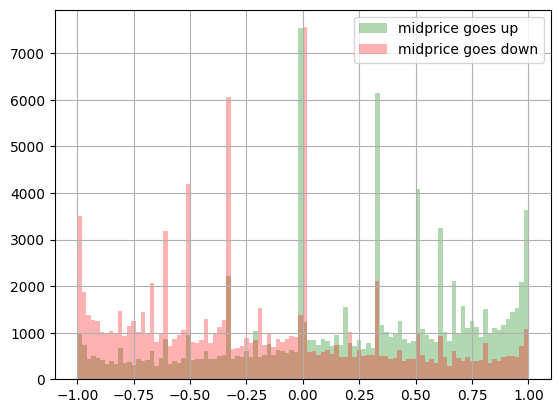

In [8]:
df[df["target"] == 1]["obi"].hist(alpha=0.3, color='g', bins=100, label='midprice goes up')
df[df["target"] == 0]["obi"].hist(alpha=0.3, color='r', bins=100, label='midprice goes down')
plt.legend()

Let us check the spike at 0.5 to understand those spikes : 

In [9]:
df[df["obi"] == 0.5]

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,lvl4_buy_vol,prev_midprice1,prev_midprice2,prev_midprice3,prev_midprice4,prev_midprice5,obi,obi_2,obi_3,obi_4
234,1,624400.0,50,624100.0,150,624500.0,100,624000.0,227,624600.0,...,210,0,1,1,1,1,0.5,0.430740,0.277978,0.102679
504,0,786200.0,1,785700.0,3,786300.0,1,785600.0,29,786400.0,...,100,1,1,1,1,1,0.5,0.882353,0.944444,0.326861
517,1,622800.0,43,622500.0,129,622900.0,139,622400.0,165,623000.0,...,190,1,0,0,0,1,0.5,0.235294,0.204878,0.222520
564,1,730600.0,1,730200.0,3,730700.0,101,730100.0,204,730800.0,...,15,0,1,0,0,0,0.5,0.339806,-0.414909,-0.394022
602,1,620800.0,100,619400.0,300,622200.0,69,619300.0,101,622400.0,...,39,0,1,0,0,1,0.5,0.407018,0.325213,0.319005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199833,0,416900.0,100,416600.0,300,417000.0,100,416500.0,451,417300.0,...,400,1,0,1,1,0,0.5,0.579390,0.478714,0.428898
199850,1,507200.0,100,507100.0,300,507600.0,600,507000.0,200,507700.0,...,500,0,1,1,1,0,0.5,-0.166667,-0.272727,-0.172414
199868,1,505000.0,100,504800.0,300,505100.0,100,504700.0,300,505200.0,...,200,1,0,1,0,1,0.5,0.500000,0.538462,0.090909
199901,1,503500.0,100,503200.0,300,503600.0,400,503100.0,422,503700.0,...,200,1,1,1,1,1,0.5,0.181669,0.437473,0.402628


There seem to be all multiples of 100. Thus, the spikes may be explained by the distribution of bid/ask volumes below:

(0.0, 1000.0)

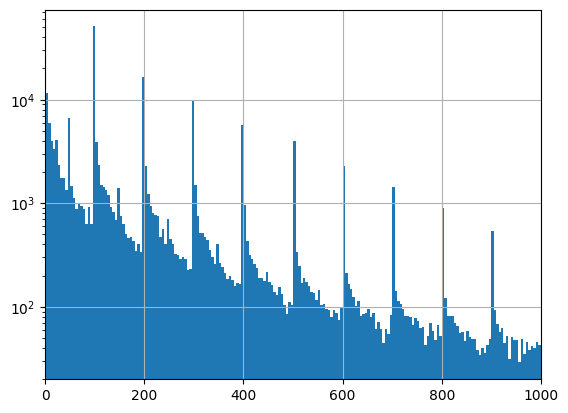

In [10]:
df[df["lvl1_buy_vol"] < 1000]["lvl1_buy_vol"].hist(bins=200, log=True)
plt.xlim(0, 1000)

There are a lot of orders corresponding to multiples of 100. 

[]

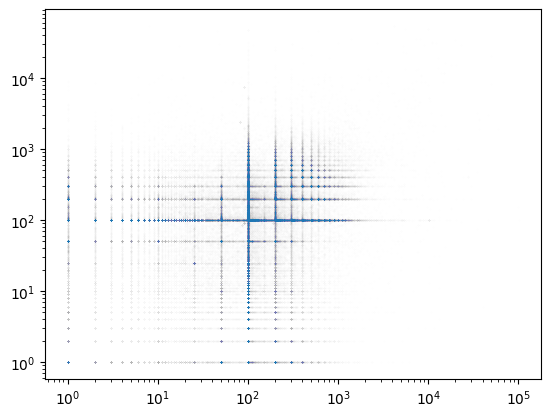

In [11]:
plt.scatter(df["lvl1_buy_vol"], df["lvl1_sell_vol"], alpha=0.01, s=0.1)
plt.loglog()

From the grid pattern we can deduce that there is a high correlation between multiples of 100 being used for buy volumes, and for ask volumes. 

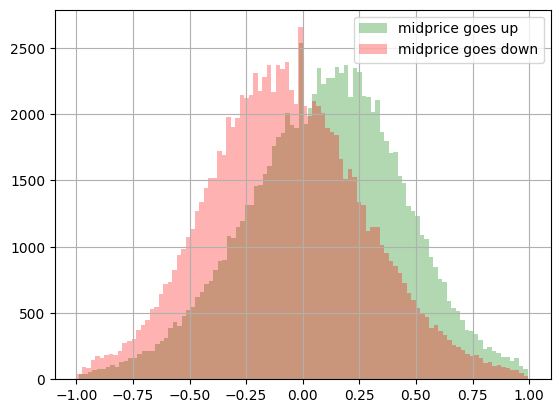

In [12]:
df[df["target"] == 1]["obi_3"].hist(alpha=0.3, color='g', bins=100, label='midprice goes up')
df[df["target"] == 0]["obi_3"].hist(alpha=0.3, color='r', bins=100, label='midprice goes down')
plt.legend()

When aggregated to several order book levels, the OBI is a bimodal gaussian distribution

In [13]:
df["spread"] = df['lvl1_sell_p'] - df['lvl1_buy_p']

<Axes: >

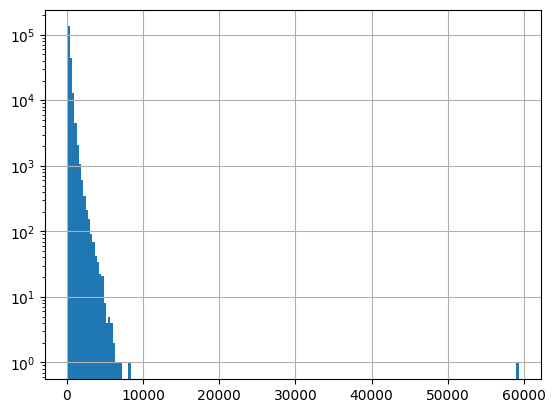

In [14]:
df["spread"].hist(bins=200, log=True)


# 1. Feature Engineering

In [15]:
df["midprice"] = (df['lvl1_sell_p'] + df['lvl1_buy_p']) / 2
df["buy_depth"] = df['lvl1_buy_vol'] + df['lvl2_buy_vol'] + df['lvl3_buy_vol'] + df['lvl4_buy_vol']
df["sell_depth"] = df['lvl1_sell_vol'] + df['lvl2_sell_vol'] + df['lvl3_sell_vol'] + df['lvl4_sell_vol']
df["sell_price_gap_1"] = df['lvl2_sell_p'] - df['lvl1_sell_p']
df["sell_price_gap_2"] = df['lvl3_sell_p'] - df['lvl2_sell_p']
df["sell_price_gap_3"] = df['lvl4_sell_p'] - df['lvl3_sell_p']
df["buy_price_gap_1"] = df['lvl1_buy_p'] - df['lvl2_buy_p']
df["buy_price_gap_2"] = df['lvl2_buy_p'] - df['lvl3_buy_p']
df["buy_price_gap_3"] = df['lvl3_buy_p'] - df['lvl4_buy_p']
df["microprice"] = (df['lvl1_sell_p'] * df['lvl1_buy_vol'] + df['lvl1_buy_p'] * df['lvl1_sell_vol']) / (df['lvl1_sell_vol'] + df['lvl1_buy_vol'])

In [16]:
#momentum features
df["momentum"] = (2*(df["prev_midprice1"] + df["prev_midprice2"] + df["prev_midprice3"] + df["prev_midprice4"] + df["prev_midprice5"])-5)/5
df["momentum_sqr"] = (2*(df["prev_midprice1"] + df["prev_midprice2"] + df["prev_midprice3"] + df["prev_midprice4"] + df["prev_midprice5"])-5)**2
df["momentum_obi"] = df["momentum"] * df["obi"]

In [17]:
df.columns

Index(['target', 'lvl1_sell_p', 'lvl1_sell_vol', 'lvl1_buy_p', 'lvl1_buy_vol',
       'lvl2_sell_p', 'lvl2_sell_vol', 'lvl2_buy_p', 'lvl2_buy_vol',
       'lvl3_sell_p', 'lvl3_sell_vol', 'lvl3_buy_p', 'lvl3_buy_vol',
       'lvl4_sell_p', 'lvl4_sell_vol', 'lvl4_buy_p', 'lvl4_buy_vol',
       'prev_midprice1', 'prev_midprice2', 'prev_midprice3', 'prev_midprice4',
       'prev_midprice5', 'obi', 'obi_2', 'obi_3', 'obi_4', 'spread',
       'midprice', 'buy_depth', 'sell_depth', 'sell_price_gap_1',
       'sell_price_gap_2', 'sell_price_gap_3', 'buy_price_gap_1',
       'buy_price_gap_2', 'buy_price_gap_3', 'microprice', 'momentum',
       'momentum_sqr', 'momentum_obi'],
      dtype='object')

# 2. Training

### 2.1 Scale / Split the data  

In [18]:
# CHANGE THE COMMENTED X LINE TO TRAIN WHETHER WITH ALL THE FEATURES OR ONLY WITH RAW DATA
# X = df.iloc[:,1:22]
X = df.iloc[:,1:]
y = df['target']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32) # '.values' so torch does not deal with pd.Series objects 
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test.values, dtype=torch.float32)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device: {device}")

Utilisation du device: cuda


### 2.2 Define the FNN class  

In [29]:
#defining the FNN

class FNN(nn.Module):
    def __init__(self, input_dim, n_layers, n_neurons_per_layer, hidden_activation, output_activation, dropout_rate):
        super(FNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for _ in range(n_layers):
            layers.append(nn.Linear(prev_dim, n_neurons_per_layer))
            layers.append(hidden_activation)
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = n_neurons_per_layer
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(output_activation)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

### 2.3 Define the Optuna Objective function to optimize hyperparameters  

In [ ]:
def objective(trial):
    #hyperparameters intervals to test
    n_layers = trial.suggest_int("n_layers", 1, 5)
    n_neurons = trial.suggest_int('n_neurons', 8, 128, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    n_epochs = trial.suggest_int('n_epochs', 5, 15)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    n_splits = 5
    hidden_act_name = trial.suggest_categorical("hidden_activation", ["ReLU", "ELU", "PreLU"])
    output_act_name = trial.suggest_categorical("output_activation", ["Sigmoid"])

    activation_dict = {
        "ReLU": nn.ReLU(),
        "Sigmoid": nn.Sigmoid(),
        "ELU": nn.ELU(),
        "PreLU": nn.PReLU()
    }

    hidden_activation = activation_dict[hidden_act_name]
    output_activation = activation_dict[output_act_name]

    accuracies = []

    #k-Fold cross validation implementation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X_tensor):
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]
    
        train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
        val_dataset = TensorDataset(X_val, y_val.unsqueeze(1))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = FNN(
        input_dim=X_tensor.shape[1],
        n_layers=n_layers,
        n_neurons_per_layer=n_neurons,
        hidden_activation=hidden_activation,
        output_activation=output_activation,
        dropout_rate=0
        ).to(device)
        
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        patience, trigger = 5, 0
        best_val_acc = 0

        
        for epoch in range(n_epochs):
            #model training
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)

                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()
        
            #model validation
            model.eval()
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device)
                    pred = model(xb)
                    pred_label = (pred > 0.5).float() 
                    all_preds.append(pred_label.cpu())
                    all_labels.append(yb.cpu())

            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)

            accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())

            #early stopping if the accuracy is stable
            if accuracy > best_val_acc:
                    best_val_acc = accuracy
                    trigger = 0
            else:
                trigger += 1
                if trigger >= patience:
                    break

        accuracies.append(accuracy)

    output_accuracy = np.mean(accuracies)

    return output_accuracy

## 2.4 Run the optimization

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CPU or GPU used: {device}")

#find best hyperparams
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters :", study.best_params)
print("Best average accuracy (CV) :", study.best_value)

best_params = study.best_params

In [ ]:
#store the best hyperparameters
import json
data = json.dumps(best_params)

with open("bestparams.json", "w") as f:
    f.write(data)

In [72]:
print(best_params)

{'n_layers': 3, 'n_neurons': 97, 'learning_rate': 0.001414178428925009, 'optimizer': 'Adam', 'n_epochs': 12, 'batch_size': 128, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid'}


## 3. Model Training / Evaluation

In [19]:
# train the final model 

train_dataset = TensorDataset(torch.tensor(X_tensor), torch.tensor(y_tensor).unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

test_dataset = TensorDataset(torch.tensor(X_tensor_test), torch.tensor(y_tensor_test).unsqueeze(1))
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=True)

with open("bestparams_with_features.json", "r", encoding="utf-8") as f:
    best_params = json.loads(f.read())

activation_dict = {
        "ReLU": nn.ReLU(),
        "Sigmoid": nn.Sigmoid(),
        "ELU": nn.ELU(),
        "PreLU": nn.PReLU()
    }

model = FNN(
            input_dim=X_tensor_test.shape[1],
            n_layers=best_params["n_layers"],
            n_neurons_per_layer=best_params["n_neurons"],
            hidden_activation=activation_dict[best_params["hidden_activation"]],
            output_activation=activation_dict[best_params["output_activation"]],
            dropout_rate=0
        ).to(device)

optimizer = getattr(optim, best_params["optimizer"])(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.BCELoss()

for epoch in range(best_params["n_epochs"]):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)

                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()
            print(f"epoch {epoch} done")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        pred_label = (pred > 0.5).float()  # convert probabilities to 0 or 1
        all_preds.append(pred_label.cpu())
        all_labels.append(yb.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())
print(accuracy)

NameError: name 'best_params' is not defined

## 3.1 Feature Importance Analysis

base test accuracy : 0.7238



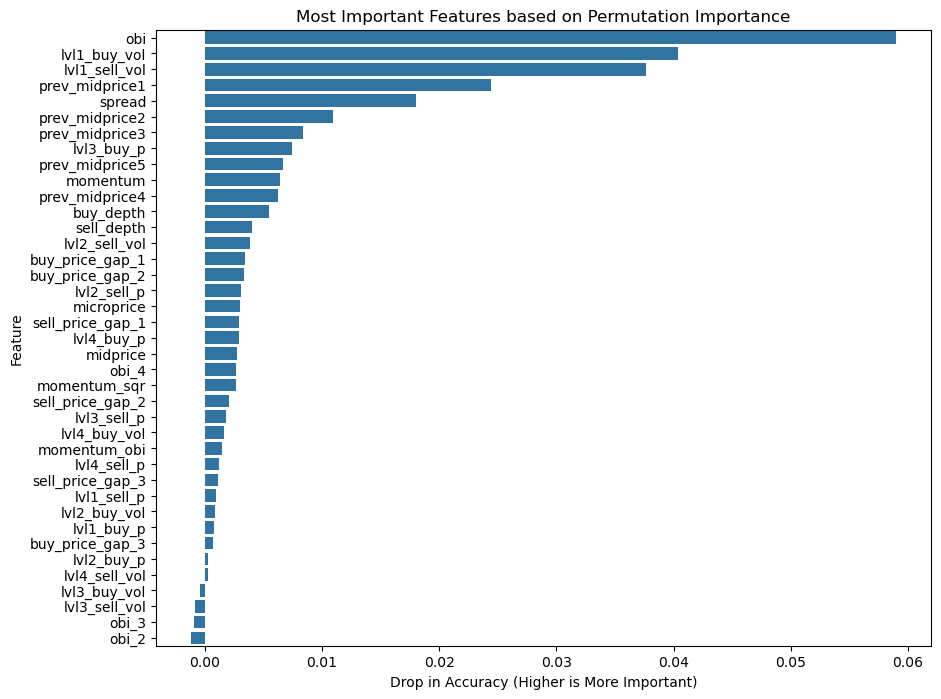

             Feature  Importance
21               obi     0.05895
3       lvl1_buy_vol     0.04040
1      lvl1_sell_vol     0.03760
16    prev_midprice1     0.02445
25            spread     0.01805
17    prev_midprice2     0.01095
18    prev_midprice3     0.00835
10        lvl3_buy_p     0.00745
20    prev_midprice5     0.00665
36          momentum     0.00645
19    prev_midprice4     0.00625
27         buy_depth     0.00550
28        sell_depth     0.00400
5      lvl2_sell_vol     0.00385
32   buy_price_gap_1     0.00345
33   buy_price_gap_2     0.00335
4        lvl2_sell_p     0.00310
35        microprice     0.00305
29  sell_price_gap_1     0.00290
14        lvl4_buy_p     0.00290
26          midprice     0.00275
24             obi_4     0.00270
37      momentum_sqr     0.00265
30  sell_price_gap_2     0.00210
8        lvl3_sell_p     0.00180
15      lvl4_buy_vol     0.00165
38      momentum_obi     0.00150
12       lvl4_sell_p     0.00120
31  sell_price_gap_3     0.00115
0        l

In [108]:
from sklearn.inspection import permutation_importance


model.eval()
with torch.no_grad():
    base_preds_raw = model(X_tensor_test.to(device)).cpu()
    base_preds = (base_preds_raw > 0.5).float().numpy()
base_accuracy = accuracy_score(y_tensor_test.numpy(), base_preds)
print(f"base test accuracy : {base_accuracy:.4f}\n")

results = []
feature_names = df.iloc[:,1:].columns

#test each feature importance
for i, feature_name in enumerate(feature_names):
    X_test_permuted = X_tensor_test.clone().numpy()
    
    #randomize feature data
    np.random.shuffle(X_test_permuted[:, i])
    
    X_test_permuted_tensor = torch.tensor(X_test_permuted, dtype=torch.float32)
    
    #inference
    with torch.no_grad():
        permuted_preds_raw = model(X_test_permuted_tensor.to(device)).cpu()
        permuted_preds = (permuted_preds_raw > 0.5).float().numpy()
    
    permuted_accuracy = accuracy_score(y_tensor_test.numpy(), permuted_preds)
    
    #feature importance computation
    importance = base_accuracy - permuted_accuracy
    results.append({'Feature': feature_name, 'Importance': importance})

perm_importance_df = pd.DataFrame(results).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title('Most Important Features based on Permutation Importance')
plt.xlabel('Drop in Accuracy (Higher is More Important)')
plt.show()

print(perm_importance_df)


# 3.2 McNemar Test

In [ ]:
X_no_features = df.iloc[:, 1:22] 
X_with_features = df.iloc[:, 1:-1] 
y = df['target']


RANDOM_SEED = 42 # Whatever number works, 42 is a convention

X_train_nf, X_test_nf, y_train, y_test = train_test_split(
    X_no_features, y, test_size=0.1, random_state=RANDOM_SEED
)
# We reuse the SAME random_state to ensure identical splits
X_train_wf, X_test_wf, _, _ = train_test_split(
    X_with_features, y, test_size=0.1, random_state=RANDOM_SEED
)

# We scale the data SEPARATELY
# Important: we "fit" the scaler on the train, and apply it to both train
scaler_nf = StandardScaler()
X_train_nf_scaled = scaler_nf.fit_transform(X_train_nf)
X_test_nf_scaled = scaler_nf.transform(X_test_nf)

scaler_wf = StandardScaler()
X_train_wf_scaled = scaler_wf.fit_transform(X_train_wf)
X_test_wf_scaled = scaler_wf.transform(X_test_wf)


X_tensor_train_no_features = torch.tensor(X_train_nf_scaled, dtype=torch.float32)
X_tensor_test_no_features = torch.tensor(X_test_nf_scaled, dtype=torch.float32)

X_tensor_train_with_features = torch.tensor(X_train_wf_scaled, dtype=torch.float32)
X_tensor_test_with_features = torch.tensor(X_test_wf_scaled, dtype=torch.float32)

y_tensor_train = torch.tensor(y_train.values, dtype=torch.float32) 
y_tensor_test = torch.tensor(y_test.values, dtype=torch.float32)

print("Data Preparation Done")
print(f"Shape X_train (no features):   {X_tensor_train_no_features.shape}")
print(f"Shape X_train (with features): {X_tensor_train_with_features.shape}")
print(f"Shape y_train:                 {y_tensor_train.shape}")

Préparation des données terminée.
Shape X_train (no features):   torch.Size([180000, 21])
Shape X_train (with features): torch.Size([180000, 38])
Shape y_train:                 torch.Size([180000])


In [ ]:
activation_dict = {
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid(),
    "ELU": nn.ELU(),
    "PreLU": nn.PReLU()
}

all_labels_for_test = None
all_preds_model_no_features = None
all_preds_model_with_features = None

# First without features, then with features

with open("bestparams.json", "r", encoding="utf-8") as f:
    best_params_1 = json.loads(f.read())

train_dataset_1 = TensorDataset(X_tensor_train_no_features, y_tensor_train.unsqueeze(1))
train_loader_1 = DataLoader(train_dataset_1, batch_size=best_params_1["batch_size"], shuffle=True)

test_dataset_1 = TensorDataset(X_tensor_test_no_features, y_tensor_test.unsqueeze(1))
# shuffle=False to ensure prediction order
test_loader_1 = DataLoader(test_dataset_1, batch_size=best_params_1["batch_size"], shuffle=False)


model_1 = FNN(
    input_dim=X_tensor_train_no_features.shape[1],
    n_layers=best_params_1["n_layers"],
    n_neurons_per_layer=best_params_1["n_neurons"],
    hidden_activation=activation_dict[best_params_1["hidden_activation"]],
    output_activation=activation_dict[best_params_1["output_activation"]],
    dropout_rate=0
).to(device)

optimizer_1 = getattr(optim, best_params_1["optimizer"])(model_1.parameters(), lr=best_params_1["learning_rate"])
criterion = nn.BCELoss()


for epoch in range(best_params_1["n_epochs"]):
    model_1.train()
    for xb, yb in train_loader_1:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_1.zero_grad()
        pred = model_1(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer_1.step()
    print(f"Model 1, Epoch {epoch} done")

all_preds = []
all_labels = []
model_1.eval()
with torch.no_grad():
    for xb, yb in test_loader_1:
        xb, yb = xb.to(device), yb.to(device)
        pred = model_1(xb)
        pred_label = (pred > 0.5).float()
        all_preds.append(pred_label.cpu())
        all_labels.append(yb.cpu())

all_preds_model_no_features = torch.cat(all_preds).numpy().flatten()
all_labels_for_test = torch.cat(all_labels).numpy().flatten() # Sera identique pour le modèle 2

print(f"Accuracy Model 1: {accuracy_score(all_labels_for_test, all_preds_model_no_features)}")


# Model 2

with open("bestparams_with_features.json", "r", encoding="utf-8") as f:
    best_params_2 = json.loads(f.read())

train_dataset_2 = TensorDataset(X_tensor_train_with_features, y_tensor_train.unsqueeze(1))
train_loader_2 = DataLoader(train_dataset_2, batch_size=best_params_2["batch_size"], shuffle=True)

test_dataset_2 = TensorDataset(X_tensor_test_with_features, y_tensor_test.unsqueeze(1))
# shuffle=False to ensure prediction order
test_loader_2 = DataLoader(test_dataset_2, batch_size=best_params_2["batch_size"], shuffle=False)

model_2 = FNN(
    input_dim=X_tensor_train_with_features.shape[1],
    n_layers=best_params_2["n_layers"],
    n_neurons_per_layer=best_params_2["n_neurons"],
    hidden_activation=activation_dict[best_params_2["hidden_activation"]],
    output_activation=activation_dict[best_params_2["output_activation"]],
    dropout_rate=0
).to(device)

optimizer_2 = getattr(optim, best_params_2["optimizer"])(model_2.parameters(), lr=best_params_2["learning_rate"])

for epoch in range(best_params_2["n_epochs"]):
    model_2.train()
    for xb, yb in train_loader_2:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_2.zero_grad()
        pred = model_2(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer_2.step()
    print(f"Model 2, Epoch {epoch} done")

all_preds = []
all_labels = [] #We recalculate to be sure, but it should be identical
model_2.eval()
with torch.no_grad():
    for xb, yb in test_loader_2:
        xb, yb = xb.to(device), yb.to(device)
        pred = model_2(xb)
        pred_label = (pred > 0.5).float()
        all_preds.append(pred_label.cpu())
        all_labels.append(yb.cpu())

all_preds_model_with_features = torch.cat(all_preds).numpy().flatten()


print(f"Accuracy Model 2: {accuracy_score(all_labels_for_test, all_preds_model_with_features)}")


# Calculate the contingency table values
correct_model1 = (all_labels_for_test == all_preds_model_no_features)
correct_model2 = (all_labels_for_test == all_preds_model_with_features)


n_11 = np.sum((correct_model1) & (correct_model2))
n_10 = np.sum((correct_model1) & (~correct_model2))
n_01 = np.sum((~correct_model1) & (correct_model2))
n_00 = np.sum((~correct_model1) & (~correct_model2))

contingency_table = [[n_11, n_10],
                     [n_01, n_00]]

result = mcnemar(contingency_table, exact=False, correction=True)

print(f"\nStatistic (Chi-sq): {result.statistic}")
print(f"P-value: {result.pvalue}")

if result.pvalue < 0.05:
    print("\nConclusion : the difference is statistically significant (p < 0.05).")
else:
    print("\nConclusion : the difference is NOT statistically significant (p >= 0.05).")

Modèle 1, Epoch 0 done
Modèle 1, Epoch 1 done
Modèle 1, Epoch 2 done
Modèle 1, Epoch 3 done
Modèle 1, Epoch 4 done
Modèle 1, Epoch 5 done
Modèle 1, Epoch 6 done
Modèle 1, Epoch 7 done
Modèle 1, Epoch 8 done
Modèle 1, Epoch 9 done
Modèle 1, Epoch 10 done
Modèle 1, Epoch 11 done
Modèle 1, Epoch 12 done
Modèle 1, Epoch 13 done
Modèle 1, Epoch 14 done
Accuracy Model 1: 0.71795
Modèle 2, Epoch 0 done
Modèle 2, Epoch 1 done
Modèle 2, Epoch 2 done
Modèle 2, Epoch 3 done
Modèle 2, Epoch 4 done
Modèle 2, Epoch 5 done
Modèle 2, Epoch 6 done
Modèle 2, Epoch 7 done
Modèle 2, Epoch 8 done
Modèle 2, Epoch 9 done
Modèle 2, Epoch 10 done
Modèle 2, Epoch 11 done
Accuracy Model 2: 0.72775

Statistic (Chi-sq): 16.85505319148936
P-value: 4.034576644781196e-05

Conclusion : the difference is statistically significant (p < 0.05).


## 4. Labels Prediction

In [ ]:
data = pd.read_csv('../DL-2025-CW-data/Data_B_nolabels.csv', names=['lvl1_sell_p', 'lvl1_sell_vol', 'lvl1_buy_p', 'lvl1_buy_vol', 'lvl2_sell_p', 'lvl2_sell_vol', 'lvl2_buy_p', 'lvl2_buy_vol', 'lvl3_sell_p', 'lvl3_sell_vol', 'lvl3_buy_p', 'lvl3_buy_vol', 'lvl4_sell_p', 'lvl4_sell_vol', 'lvl4_buy_p', 'lvl4_buy_vol', 'prev_midprice1', 'prev_midprice2', 'prev_midprice3', 'prev_midprice4', 'prev_midprice5'])

#Features Creation
data["obi"] = (data['lvl1_buy_vol'] - data['lvl1_sell_vol']) / (data['lvl1_buy_vol'] + data['lvl1_sell_vol'])
data["obi_2"] = (data['lvl2_buy_vol'] + data['lvl1_buy_vol'] - data['lvl2_sell_vol'] - data['lvl1_sell_vol']) / (data['lvl2_buy_vol'] + data['lvl1_buy_vol'] + data['lvl2_sell_vol'] + data['lvl1_sell_vol'])
data["obi_3"] = (data['lvl3_buy_vol'] + data['lvl2_buy_vol'] + data['lvl1_buy_vol'] - data['lvl3_sell_vol'] - data['lvl2_sell_vol'] - data['lvl1_sell_vol']) / (data['lvl3_buy_vol'] + data['lvl2_buy_vol'] + data['lvl1_buy_vol'] + data['lvl3_sell_vol'] + data['lvl2_sell_vol'] + data['lvl1_sell_vol'])
data["obi_4"] = (data['lvl4_buy_vol'] + data['lvl3_buy_vol'] + data['lvl2_buy_vol'] + data['lvl1_buy_vol'] - data['lvl4_sell_vol'] - data['lvl3_sell_vol'] - data['lvl2_sell_vol'] - data['lvl1_sell_vol']) / (data['lvl4_buy_vol'] + data['lvl3_buy_vol'] + data['lvl2_buy_vol'] + data['lvl1_buy_vol'] + data['lvl4_sell_vol'] + data['lvl3_sell_vol'] + data['lvl2_sell_vol'] + data['lvl1_sell_vol'])
data["spread"] = data['lvl1_sell_p'] - data['lvl1_buy_p']
data["midprice"] = (data['lvl1_sell_p'] + data['lvl1_buy_p']) / 2
data["buy_depth"] = data['lvl1_buy_vol'] + data['lvl2_buy_vol'] + data['lvl3_buy_vol'] + data['lvl4_buy_vol']
data["sell_depth"] = data['lvl1_sell_vol'] + data['lvl2_sell_vol'] +data['lvl3_sell_vol'] + data['lvl4_sell_vol']
data["sell_price_gap_1"] = data['lvl2_sell_p'] - data['lvl1_sell_p']
data["sell_price_gap_2"] = data['lvl3_sell_p'] - data['lvl2_sell_p']
data["sell_price_gap_3"] = data['lvl4_sell_p'] - data['lvl3_sell_p']
data["buy_price_gap_1"] = data['lvl1_buy_p'] - data['lvl2_buy_p']
data["buy_price_gap_2"] = data['lvl2_buy_p'] - data['lvl3_buy_p']
data["buy_price_gap_3"] = data['lvl3_buy_p'] - data['lvl4_buy_p']
data["microprice"] = (data['lvl1_sell_p'] * data['lvl1_buy_vol'] + data['lvl1_buy_p'] * data['lvl1_sell_vol']) / (data['lvl1_sell_vol'] + data['lvl1_buy_vol'])
data["momentum"] = (2*(data["prev_midprice1"] + data["prev_midprice2"] + data["prev_midprice3"] + data["prev_midprice4"] + data["prev_midprice5"])-5)/5
data["momentum_sqr"] = (2*(data["prev_midprice1"] + data["prev_midprice2"] + data["prev_midprice3"] + data["prev_midprice4"] + data["prev_midprice5"])-5)**2
data["momentum_obi"] = data["momentum"] * data["obi"]

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

pred_tensor = torch.tensor(data, dtype=torch.float32)

all_preds = []

model.eval()
with torch.no_grad():
    for xb in pred_tensor:
        xb = xb.to(device)
        pred_raw = model(xb)
        pred = (pred_raw > 0.5).float()
        all_preds.append(pred)

In [178]:
with open("06058642_Ramim.txt", "w", encoding="utf-8") as f:
    print(len(all_preds))
    for i in range(len(all_preds)):
        f.write(str(int(all_preds[i]))+"\n")

20000
